# Modelo Híbrido

* Se predice la periocidad con un regresor linear.

* Se calcula el residuo, restando a la salida lo predicho por el modelo lineal (y-ypred-lin).

* Se usan los otros regresores para predecir el yresiduo, en este caso la temperatura y el precio del MWh.

* **Contras**: Se debe conocer la temperatura y el precio del MWh para predecir el consumo.

* https://www.kaggle.com/code/ryanholbrook/hybrid-models

In [133]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
import sys
sys.path.append('../src')

In [ ]:
#!pip install xgboost
#!pip install graphviz

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from prophet import Prophet

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import graphviz
from sklearn.tree import plot_tree


from xgboost import XGBRegressor
from xgboost import plot_tree

/home/adrian/.conda/envs/time-series/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Cosntrucción del dataset

Esta primer dataset contiene el consumo energetico **y** y la temperatura registrada **tmp** por dia:

In [3]:
DATASET_PATH = 'https://raw.githubusercontent.com/magistery-tps/time-series-tp/master/datasets/consumo_energetico_diario.csv'

dataset         = pd.read_csv(DATASET_PATH,parse_dates=['dia'])
dataset.columns = dataset.columns.str.lower()
dataset.rename(columns={'dia':'ds','mwh':'y'}, inplace=True)

dataset.head()

,ds,y,tmp
0,2005-12-01,81445.928,18.104167
1,2005-12-02,81749.888,17.904167
2,2005-12-03,72134.590,19.562500
3,2005-12-04,63452.628,18.854167
4,2005-12-05,81508.078,21.941667


Este segundo dataset tiene el precio normalizado por kw/h ajustado por inflación:

In [5]:
DATASET_PATH = 'https://raw.githubusercontent.com/magistery-tps/time-series-tp/leandro/datasets/regresores_v1.csv'

dataset_regresores         = pd.read_csv(DATASET_PATH, parse_dates=['fecha'])
dataset_regresores.columns = dataset_regresores.columns.str.lower()

dataset_regresores.drop(['dia'], axis=1,inplace=True)
dataset_regresores.rename(columns={'fecha':'ds'},inplace=True)

dataset_regresores = dataset_regresores[['ds','precio_kwh_norm_new']]

Se agregan todas las columnas en un unico dataset:

In [7]:
dataset = dataset.merge(dataset_regresores, how='left')
dataset

,ds,y,tmp,precio_kwh_norm_new
0,2005-12-01,81445.928000,18.104167,NaN
1,2005-12-02,81749.888000,17.904167,NaN
2,2005-12-03,72134.590000,19.562500,NaN
3,2005-12-04,63452.628000,18.854167,NaN
4,2005-12-05,81508.078000,21.941667,NaN
...,...,...,...,...
5717,2021-07-27,163043.900635,8.475000,0.072498
5718,2021-07-28,172692.328857,7.916667,0.072429
5719,2021-07-29,167475.483154,8.195833,0.072360
5720,2021-07-30,157115.490479,9.679167,0.072291


Donde:

* **ds**: El la fecha del dia.
* **y**: Es e consumo energetico por KW/H.
* **precio_kwh_norm_new**: Precio del KW/K.

## Funciones Auxiliares

Modelo Hibrido:

In [16]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1   = model_1
        self.model_2   = model_2
        self.y_columns = None  # store column names from fit method

    def fit(self, X_1, X_2, y):
        y1 = y.copy()  # the target

        self.model_1.fit(X_1, y1)

        r_sq = self.model_1.score(X_1, y1)
        print(f"coefficient of determination: {r_sq}")
        print(f"intercept: {self.model_1.intercept_}")
        print(f"slope: {self.model_1.coef_}")

        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index = X_1.index,
            #, columns=y.columns,
        )
        y_fit.rename(columns={0:'value'}, inplace=True)

        y_resid = y - y_fit['value']
        y_resid = y_resid.squeeze()
        self.model_2.fit(X_2, y_resid)
        self.y_fit = y_fit
        self.y_resid = y_resid

        # Visualizaciones del modelo
        sns.set(rc = {'figure.figsize':(22,8)})
        sns.set_style("darkgrid")
        plt.plot(y1,color='green',label="True")
        plt.plot(y_fit,color='blue', label="Prediction")
        plt.title("Linear prediction")
        plt.legend()
        plt.show()

        feature_important = self.model_2.get_booster().get_score(importance_type='weight')
        print('Feature importance:',feature_important)
        _, ax = plt.subplots(figsize=(20,20)) # Resize figure
        plot_tree(self.model_2,rankdir='LR',ax=ax) #, fontsize=10
        plt.show()


    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, 
        )  
        y_pred = self.model_1.predict(X_1)
        y_pred += self.model_2.predict(X_2)
        return y_pred

In [17]:
def smape_loss(y_true, y_pred):
    """SMAPE Loss"""
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200


def entrenamiento(train, test):
    X_train = train.copy()
    X_train.rename(columns={'ds':'date','y':'value'},inplace=True)    
  
    X_val = test.copy()
    X_val.rename(columns={'ds':'date','y':'value'},inplace=True)
  
    X_train = X_train.set_index('date')
    X_val   = X_val.set_index('date')
    y_train = X_train.value
    y_val   = X_val.value

    N_test  = len(y_val)

    fourier = CalendarFourier(freq="A", order=4)

    dp = DeterministicProcess(
      index            = X_train.index,
      constant         = False,
      order            = 1,
      seasonal         = True,       # weekly seasonality (indicators)
      additional_terms = [fourier],  # monthly seasonality (fourier)
      drop             = True
    )
    
    X1      = dp.in_sample()
    X1_fore = dp.out_of_sample(N_test, forecast_index = X_val.index)
    
      
    # Temperatura + Precio
    X2 = np.hstack([X_train[['tmp', 'precio_kwh_norm_new']]])
    #X2= np.hstack([X_train[['tmp']]])

    X2_fore = np.hstack([X_val[['tmp', 'precio_kwh_norm_new']]])
    #X2_fore=np.hstack([X_val[['tmp']]]) 

    model = BoostedHybrid(
        model_1 = LinearRegression(fit_intercept=True),
        # model_1 = Ridge(),

        model_2 = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 100),
        # model_2 = XGBRegressor(colsample_bytree = 0.2, learning_rate = 0.1, max_depth = 5, n_estimators = 200),
    )

    model.fit(X1, X2, y_train)
    
    y_pred = model.predict(X1, X2)
    y_pred_df = pd.DataFrame(
        y_pred,
        index=X_train.index,
    )  
    
    y_pred_future = model.predict(X1_fore,X2_fore)
    y_pred_future_df = pd.DataFrame(
        y_pred_future,
        index=X_val.index,
    ) 
    
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.set_style("darkgrid")
    plt.plot(y_train,color='green',label="True")
    plt.plot(y_pred_df,color='blue', label="Prediction")
    plt.title("hybrid -  train")
    plt.legend()
    plt.show()
    

    sns.set_style("darkgrid")
    plt.plot(y_val,color='green',label="True")
    plt.plot(y_pred_future_df,color='blue', label="Prediction")
    plt.title("hybrid -  test")
    plt.legend()
    plt.show()

    
    smape_mean=smape_loss(np.array(y_val), np.array(y_pred_future)).mean()

    mse = mean_squared_error(y_val, y_pred_future_df)
    mae = mean_absolute_error(y_val, y_pred_future_df)
    mape = mean_absolute_percentage_error(y_val, y_pred_future_df)
    print('Test - Error cuadratico medio: ', mse)
    print('Test - Error absoluto medio: ',mae)
    print('Test - Error porcentual abs:',mape)

    return smape_mean

## Pre-procesamiento

Se construcción de los conjuntos de entrenamiento y test.

**Train set**

 Es una venta entre 03-06-2012 y 31/12/2019.

In [18]:
tiempo_ini = '12-31-2005' # Serie completa

train_set = dataset[(dataset.ds > tiempo_ini) & (dataset.ds < '1-1-2020')] # Ultimo dia train 31/12/2019, 
train_set.reset_index(inplace=True)

**Test set**

Es una venta a partir del 1-1-2020 inclusive.

In [19]:
test_set = dataset[(dataset.ds >= '1-1-2020')] #ultimo dia train 31/12/2019
test_set.reset_index(inplace=True)

N_test = len(test_set)

**Aclaraciones y observaciones**

* Acoto desde el cambio de **CUSUMChangePoint 2012** en adelante, ya que las oscilaciones se ven de amplitud mas constante. 
* Al observar los años 2006 a 2011, parecen ir creciendo la tendencia de consumo de energía.

## Entrenamiento

coefficient of determination: 0.6287265070064454

intercept: 90310.14680270935

slope: [ 6.36550783e+00 -1.63110849e+04  1.87573545e+03  5.60899170e+03
  6.27302039e+03  5.91669181e+03  4.65259294e+03 -8.01594736e+03
  1.04528927e+02 -5.46983961e+03  5.20400634e+03  1.09086356e+04
  1.15883280e+03 -1.12666407e+03 -4.95933516e+02 -3.61122975e+02]

<Figure size 1584x576 with 1 Axes>

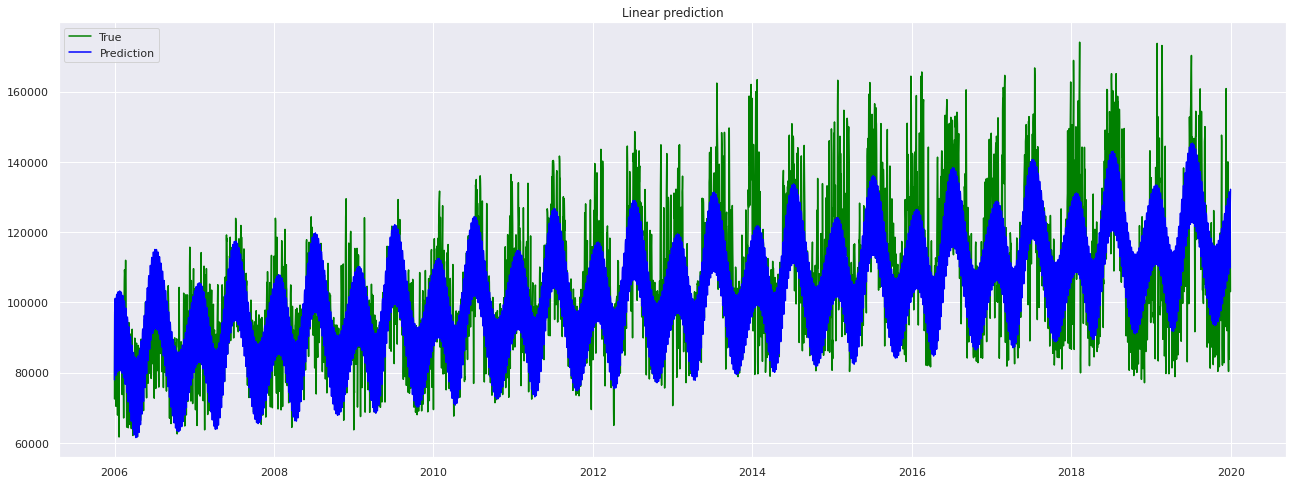

Feature importance:
{'f0': 1055.0, 'f1': 1624.0}

<Figure size 1440x1440 with 1 Axes>

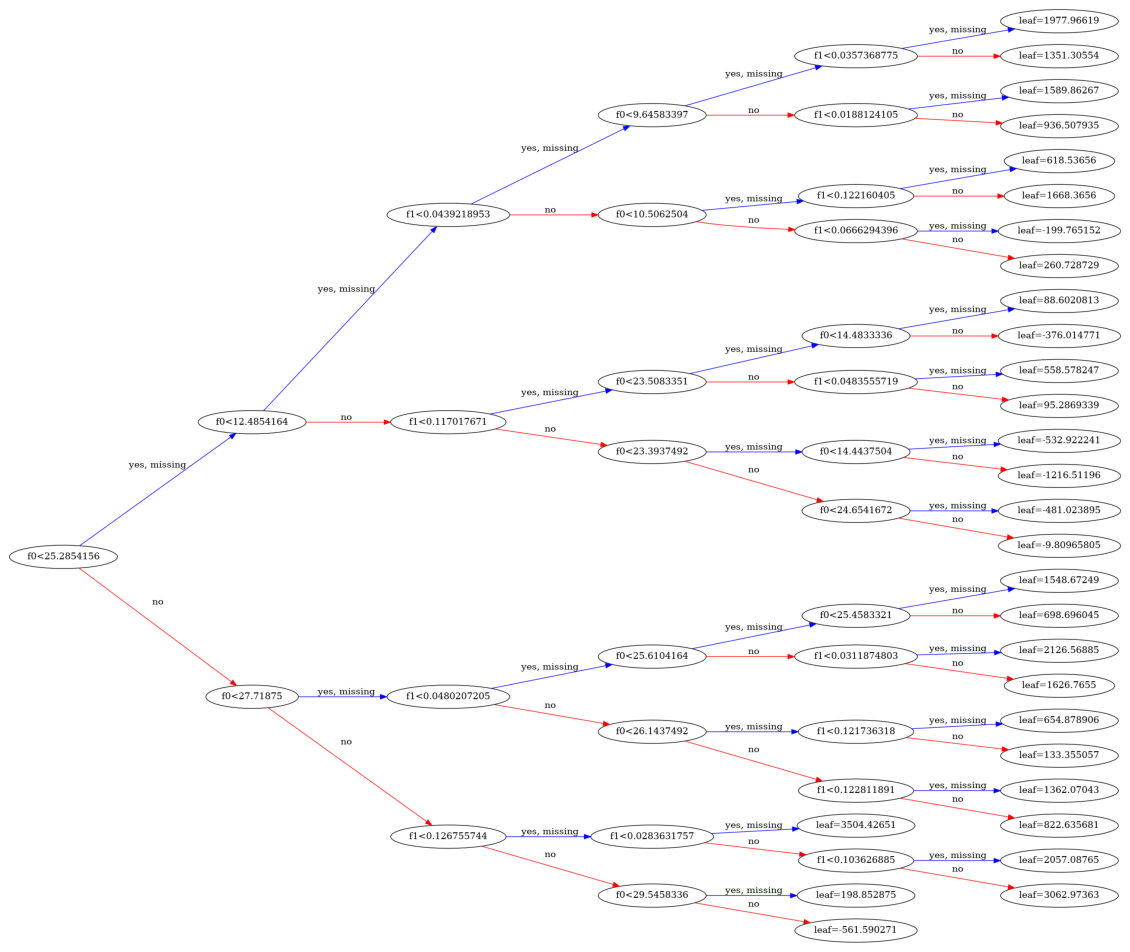

<Figure size 1080x576 with 1 Axes>

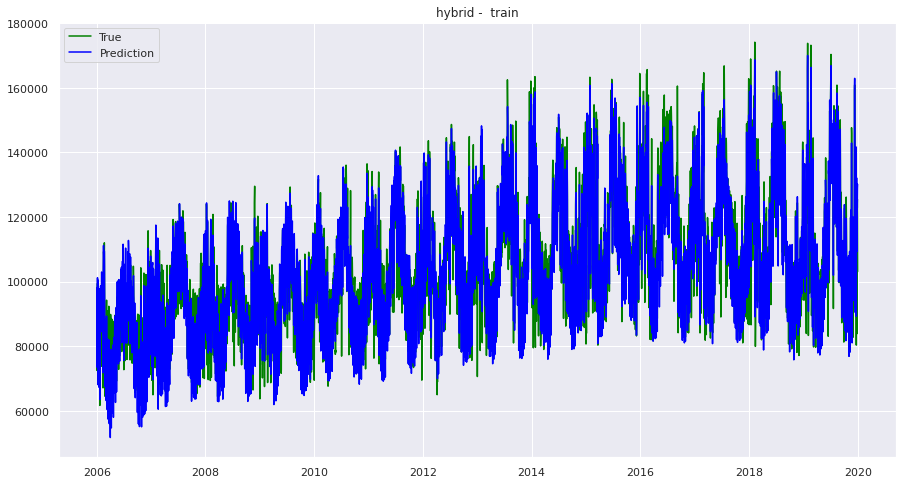

<Figure size 1080x576 with 1 Axes>

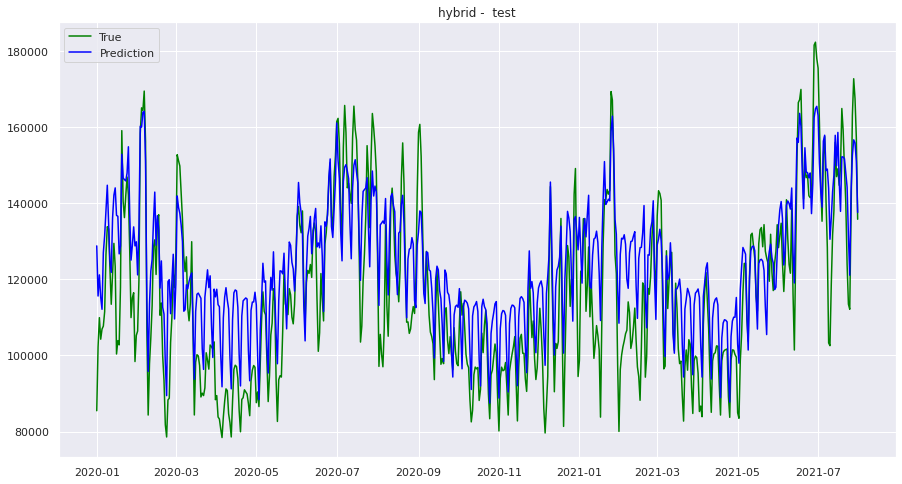

Test - Error cuadratico medio:  200361901.60745773

Test - Error absoluto medio:  11643.042657066057

Test - Error porcentual abs: 0.10996665357932309

10.201093130117359

In [20]:
entrenamiento(train_set, test_set)